In [1]:
from pandas import read_csv, DataFrame
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from matplotlib import pyplot
pyplot.rcParams["figure.figsize"] = (20,10)

In [7]:
def split_dataframe(df, chunk_size = 100): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunk = df[i*chunk_size:(i+1)*chunk_size]
        if len(chunk) > 0:
            chunks.append(chunk)
    return chunks

def join_dataframe(list_of_datraframes):
    df = DataFrame()
    for dataframe in list_of_datraframes:
        df = df.append(dataframe)
    return df

In [8]:
csvs = ['../../data_set2/data_age_based.csv',
        '../../data_set2/data_hospital.csv',
           '../../data_set2/data_response_measures.csv',
               '../../data_set2/data_testing.csv',
           '../../data_set2/data_vaccine.csv', 
       '../../data_set2/data_vaccine_map/dataset_vaccine_and_testing.csv']
datasets = []
csv_testing = csvs[3]
data = read_csv(csv_testing, index_col=2, parse_dates=True, squeeze=True)
datasets.append(data)


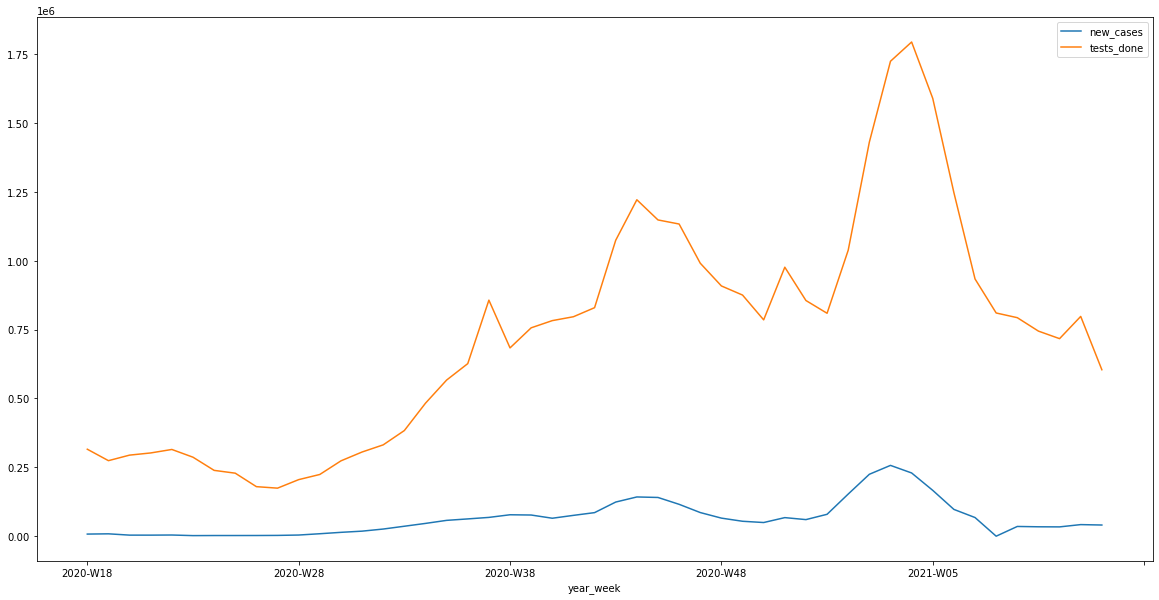

In [27]:
dataset_number = 0
country_code = 'ES'
dataset = datasets[dataset_number]
working_dataset_testing = dataset[dataset['country_code']==country_code].copy().drop('country', axis='columns').drop('country_code', axis='columns').drop('level', axis='columns').drop('region', axis='columns').drop('region_name', axis='columns').drop('population', axis='columns').drop('testing_rate', axis='columns').drop('positivity_rate', axis='columns').drop('testing_data_source', axis='columns')

alg = LocalOutlierFactor(novelty=True, n_neighbors=200)

# print(working_dataset_testing)
working_dataset_testing.plot()
pyplot.show()

C:\Users\ioana\anaconda3\lib\site-packages\sklearn\neighbors\_lof.py:265: UserWarning: n_neighbors (200) is greater than the total number of samples (49). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn("n_neighbors (%s) is greater than the "


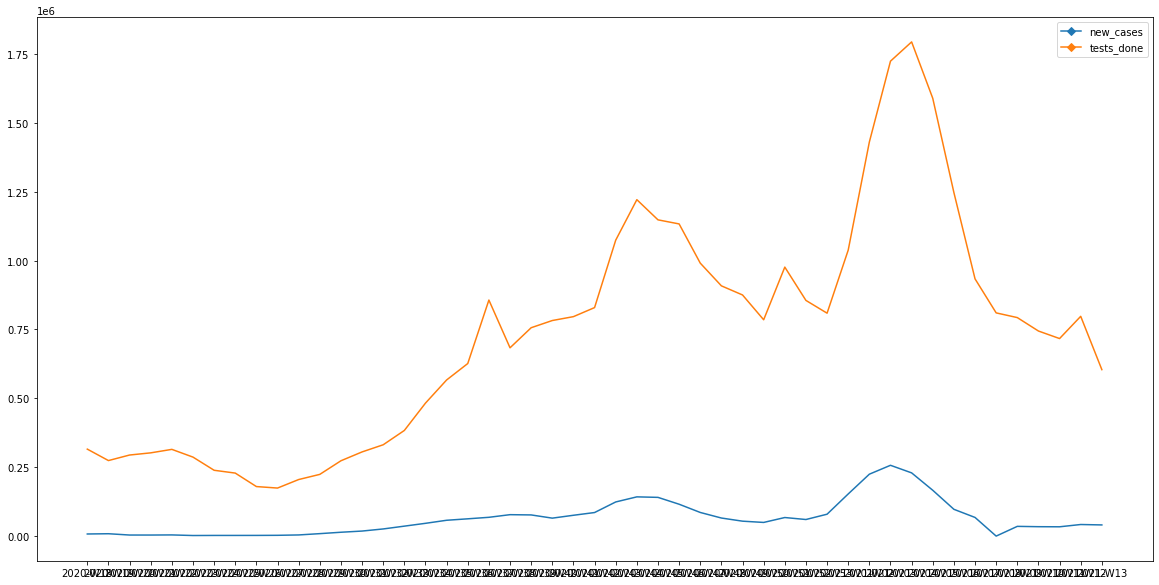

fit on all, predict on all
Number of outliers:
0
Wall time: 601 ms


In [10]:
%%time
#fit on all, predict on all

clf = alg.fit(working_dataset_testing)
pred = clf.predict(working_dataset_testing)
indices = [index for index, element in enumerate(pred) if element == -1]
pyplot.plot(working_dataset_testing, '-D', markevery=indices)
pyplot.legend(['new_cases', 'tests_done'])
pyplot.show()
print("fit on all, predict on all")
print("Number of outliers:")
print(len(indices))

C:\Users\ioana\anaconda3\lib\site-packages\sklearn\neighbors\_lof.py:265: UserWarning: n_neighbors (200) is greater than the total number of samples (4). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn("n_neighbors (%s) is greater than the "
C:\Users\ioana\anaconda3\lib\site-packages\sklearn\neighbors\_lof.py:265: UserWarning: n_neighbors (200) is greater than the total number of samples (4). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn("n_neighbors (%s) is greater than the "
C:\Users\ioana\anaconda3\lib\site-packages\sklearn\neighbors\_lof.py:265: UserWarning: n_neighbors (200) is greater than the total number of samples (4). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn("n_neighbors (%s) is greater than the "
C:\Users\ioana\anaconda3\lib\site-packages\sklearn\neighbors\_lof.py:265: UserWarning: n_neighbors (200) is greater than the total number of samples (4). n_neighbors will be set to (n_samples -

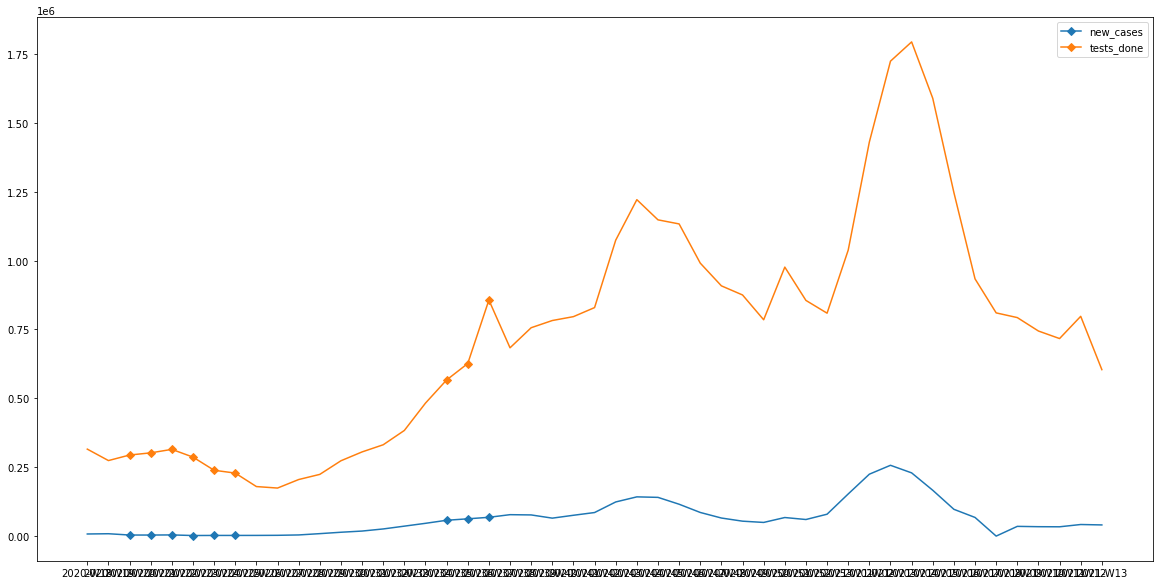

Wall time: 643 ms


In [19]:
%%time
#fit on half a period, predict on period, period == chunck_size

#split in chuncks of x weeks
fit_size = 4
chunck_size = fit_size * 2
chuncks = split_dataframe(working_dataset_testing, chunck_size)
pred = []

for chunck in chuncks:
    time_frame = split_dataframe(chunck, fit_size)
    try:
        clf = alg.fit(time_frame[0])
        pred.extend(clf.predict(join_dataframe(time_frame[1:])).tolist())
    except:
        pass
    
# -1 is an anomaly and 1 is ok
indices = [index for index, element in enumerate(pred) if element == -1]
pyplot.plot(working_dataset_testing, '-D', markevery=indices)
pyplot.legend(['new_cases', 'tests_done'])
pyplot.show()

C:\Users\ioana\anaconda3\lib\site-packages\sklearn\neighbors\_lof.py:265: UserWarning: n_neighbors (200) is greater than the total number of samples (4). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn("n_neighbors (%s) is greater than the "
C:\Users\ioana\anaconda3\lib\site-packages\sklearn\neighbors\_lof.py:265: UserWarning: n_neighbors (200) is greater than the total number of samples (8). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn("n_neighbors (%s) is greater than the "
C:\Users\ioana\anaconda3\lib\site-packages\sklearn\neighbors\_lof.py:265: UserWarning: n_neighbors (200) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn("n_neighbors (%s) is greater than the "
C:\Users\ioana\anaconda3\lib\site-packages\sklearn\neighbors\_lof.py:265: UserWarning: n_neighbors (200) is greater than the total number of samples (16). n_neighbors will be set to (n_samples

overlapped
total outliers: 6


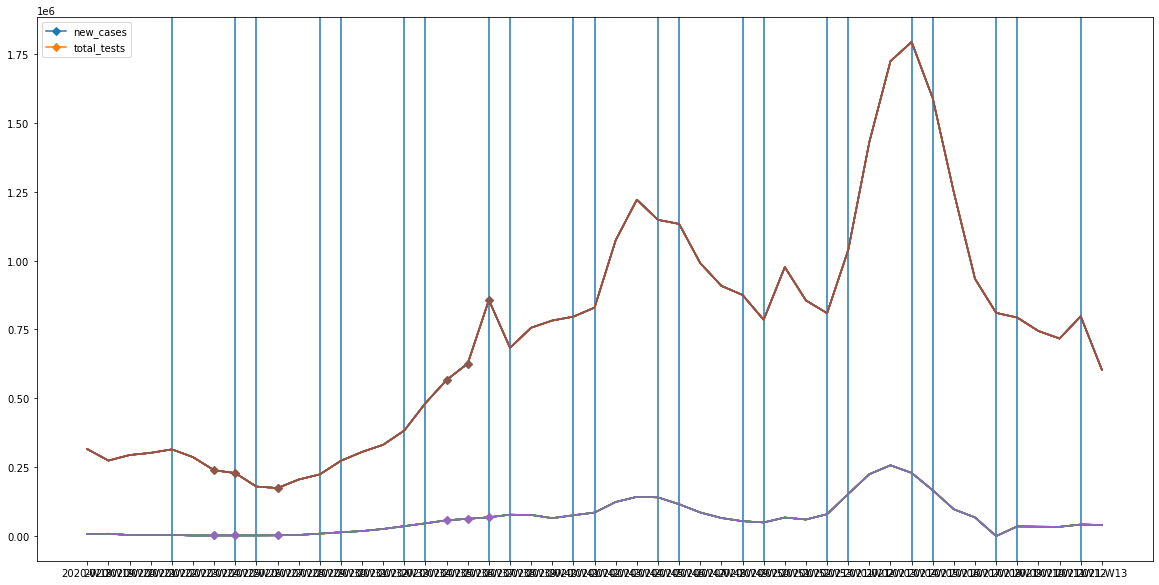

Wall time: 1.04 s


In [28]:
%%time
#fit on past, predict on current month

#split in chuncks of x weeks
chunck_size = 4
chuncks = split_dataframe(working_dataset_testing, chunck_size)
total_indices = []

for index, current in enumerate(chuncks[1:], start=1):
    until_current = join_dataframe(chuncks[:index])
    
    clf = alg.fit(until_current)
    pred = clf.predict(current).tolist()
    indices = [num + index * chunck_size for num, element in enumerate(pred) if element == -1]
    total_indices.extend(indices)
    vertical_marks = []
    pyplot.plot(working_dataset_testing, '-D', markevery=indices)
    try:
        start_incides = index * chunck_size
        end_incides = ( index + 1 ) * chunck_size - 1 
        vertical_marks = [working_dataset_testing.iloc[start_incides].name, working_dataset_testing.iloc[end_incides].name]
        pyplot.axvline(x=vertical_marks[0])
        pyplot.axvline(x=vertical_marks[1])
    except:
        pass
#     pyplot.legend(['new_cases', 'total_tests'])
#     pyplot.show()
    
print("overlapped")
print(f"total outliers: {len(total_indices)}")
pyplot.plot(working_dataset_testing, '-D', markevery=total_indices)
pyplot.legend(['new_cases', 'total_tests'])
pyplot.show()

C:\Users\ioana\anaconda3\lib\site-packages\sklearn\neighbors\_lof.py:265: UserWarning: n_neighbors (200) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn("n_neighbors (%s) is greater than the "
C:\Users\ioana\anaconda3\lib\site-packages\sklearn\neighbors\_lof.py:265: UserWarning: n_neighbors (200) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn("n_neighbors (%s) is greater than the "
C:\Users\ioana\anaconda3\lib\site-packages\sklearn\neighbors\_lof.py:265: UserWarning: n_neighbors (200) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn("n_neighbors (%s) is greater than the "
C:\Users\ioana\anaconda3\lib\site-packages\sklearn\neighbors\_lof.py:265: UserWarning: n_neighbors (200) is greater than the total number of samples (13). n_neighbors will be set to (n_sampl

C:\Users\ioana\anaconda3\lib\site-packages\sklearn\neighbors\_lof.py:265: UserWarning: n_neighbors (200) is greater than the total number of samples (42). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn("n_neighbors (%s) is greater than the "
C:\Users\ioana\anaconda3\lib\site-packages\sklearn\neighbors\_lof.py:265: UserWarning: n_neighbors (200) is greater than the total number of samples (43). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn("n_neighbors (%s) is greater than the "
C:\Users\ioana\anaconda3\lib\site-packages\sklearn\neighbors\_lof.py:265: UserWarning: n_neighbors (200) is greater than the total number of samples (44). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn("n_neighbors (%s) is greater than the "
C:\Users\ioana\anaconda3\lib\site-packages\sklearn\neighbors\_lof.py:265: UserWarning: n_neighbors (200) is greater than the total number of samples (45). n_neighbors will be set to (n_sampl

overlapped
total outliers: 1


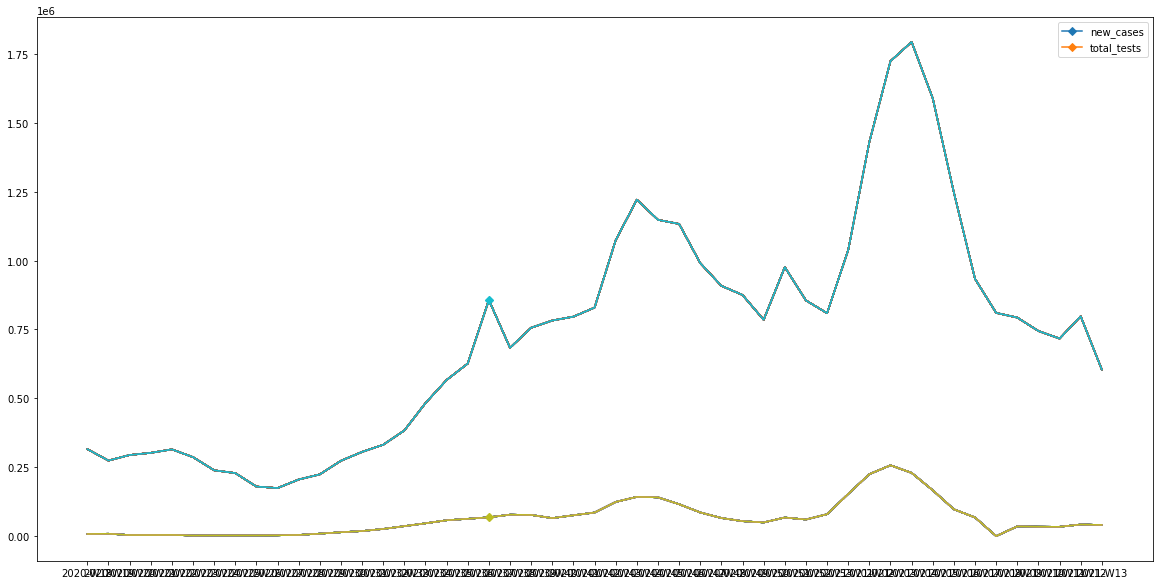

Wall time: 2.14 s


In [30]:
%%time
#fit on past, predict on current week

#split in chuncks of x weeks
chunck_size = 1
chuncks = split_dataframe(working_dataset_testing, chunck_size)
total_indices = []
for index, current in enumerate(chuncks[1:], start=1):
    if index < 10:
        continue
    until_current = join_dataframe(chuncks[:index])
    clf = alg.fit(until_current)
    pred = clf.predict(current).tolist()
    indices = [num + index * chunck_size for num, element in enumerate(pred) if element == -1]
    total_indices.extend(indices)
    vertical_marks = []
    pyplot.plot(working_dataset_testing, '-D', markevery=indices)
    try:
        start_incides = index * chunck_size
        end_incides = ( index + 1 ) * chunck_size - 1 
        vertical_marks = [working_dataset_testing.iloc[start_incides].name, working_dataset_testing.iloc[end_incides].name]
#         pyplot.axvline(x=vertical_marks[0])
#         pyplot.axvline(x=vertical_marks[1])
    except:
        pass
    
print("overlapped")
print(f"total outliers: {len(total_indices)}")
pyplot.plot(working_dataset_testing, '-D', markevery=total_indices)
pyplot.legend(['new_cases', 'total_tests'])
pyplot.show()
